<a href="https://colab.research.google.com/github/markusdobler/fast-neural-style-transfer/blob/master/TF_Hub_Fast_Style_Transfer_for_Arbitrary_Styles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

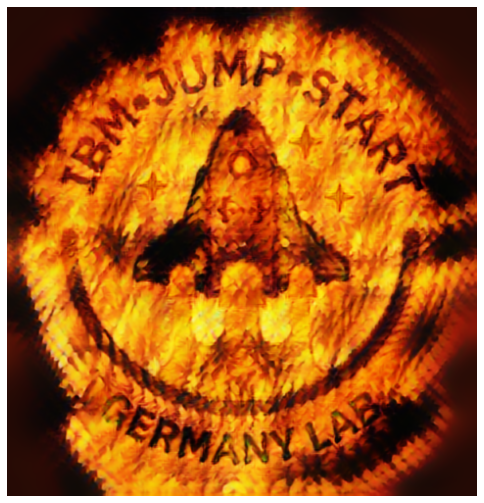 Fast Style Transfer

##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Fast Style Transfer for Arbitrary Styles


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_arbitrary_image_stylization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_arbitrary_image_stylization.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_arbitrary_image_stylization.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Based on the model code in [magenta](https://github.com/tensorflow/magenta/tree/master/magenta/models/arbitrary_image_stylization) and the publication:

[Exploring the structure of a real-time, arbitrary neural artistic stylization
network](https://arxiv.org/abs/1705.06830).
*Golnaz Ghiasi, Honglak Lee,
Manjunath Kudlur, Vincent Dumoulin, Jonathon Shlens*,
Proceedings of the British Machine Vision Conference (BMVC), 2017.

Adapted from [the TensorFlow tutorial "*TF-Hub: Fast Style Transfer for Arbitrary Styles*"](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization)

## Setup

In [ ]:
#@title Import TF-2 and all relevant dependencies.  { display-mode: "form" }
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

In [ ]:
# @title Define image loading and visualization functions.  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_path_or_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  if "://" in image_path_or_url:
      image_path = tf.keras.utils.get_file(os.path.basename(image_path_or_url)[-128:], image_path_or_url)
  else:
      image_path = image_path_or_url
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path)[:,:,:3].astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  # img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=preserve_aspect_ratio)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


In [ ]:
#@title Load TF-Hub module.  { display-mode: "form" }

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

## Demonstrate image stylization

In [ ]:
#@title Create your own stylized images.  { display-mode: "form" }

#@markdown ---
#@markdown ###### Either provide a URL (starting with 'http[s]://'), or upload your image (see the folder icon on the left sidebar) and then use 'Copy path' in the context menu
#@markdown ---

content_image_path_or_url = 'https://upload.wikimedia.org/wikipedia/commons/a/af/Tux.png'  # @param {type:"string"}
style_image_path_or_url = 'https://upload.wikimedia.org/wikipedia/commons/3/36/Large_bonfire.jpg'  # @param {type:"string"}


output_image_size = 500  # @param {type:"integer"}

content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_path_or_url, content_img_size)
style_image = load_image(style_image_path_or_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

show_n([stylized_image], titles=[])
show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])